
Import necessary library


In [1]:
from xml.dom import minidom
import re
import numpy as np
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import math

In [2]:
# from nltk.corpus import stopwords
# stopwords.words('english')

<br>
<br>
Data Cleaning Functions
<br>
<br>

In [3]:
TAG_RE = re.compile(r'<[^>]+>|\'')
def remove_tags(text):
    return TAG_RE.sub('', text)

PUNC_TAG = re.compile(r'[^a-zA-Z0-9_]')
def remove_punctuation(text):
    return PUNC_TAG.sub(' ', text)

Spaces = re.compile(r'  *')
def remove_spaces(text):
    return Spaces.sub(' ', text)

def remove_junk(string):
    return (remove_spaces(remove_punctuation(remove_tags(string)))).lower()


<br>
<br>
loading stop words in a list
<br>
<br>

In [4]:
# https://github.com/Alir3z4/stop-words/blob/master/english.txt
file = open('english.txt', 'r')
stopwords = []

for i in file.readlines():
    i = i.split()
    stopwords = stopwords + i

file.close()
# other stopwords collections
# https://streamhacker.com/2010/05/24/text-classification-sentiment-analysis-stopwords-collocations/

<br>
<br>
<h5>Word Stemming and Lemmatization Functions</h5>
<a href="https://gist.github.com/mmmayo13/07252b4eb27e5495b6032888b38e5333#file-text_data_preprocessing_5-py" target="_blank">more on this link</a>
<br>
<br>

In [5]:
# https://gist.github.com/mmmayo13/07252b4eb27e5495b6032888b38e5333#file-text_data_preprocessing_5-py
def stem_word(word):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()   
    return stemmer.stem(word)

def lemmatize_verb(word):
    """Lemmatize verbs"""
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(word, pos='v')

def lemm(word):
    """Lemmatize nouns"""
    wordnet_lemmatizer = WordNetLemmatizer()
    return wordnet_lemmatizer.lemmatize(word)

def pot(word):
    porter_stemmer = PorterStemmer()
    return porter_stemmer.stem(word)


<br>
<br>
<b>functions to build wordlist and vectors
<br>
<br>

In [6]:
def build_wordlist(filelocation, stopwords, wordmap, index, MAX_ROWS = 200):
    
    # parse an xml file by name
    mydoc = minidom.parse(filelocation)
    
    # get each row in the file
    items = mydoc.getElementsByTagName('row')
    count=0
    
    for item in items:
        
        # remove unnecessary things
        string = remove_junk(item.attributes['Body'].value)
        
        # not count a paragraph without any value
        if len(string) < 2:
            continue
        
        count=count+1
        if count==MAX_ROWS:
            break
        
        # check every single words in the string
        words = string.split(" ")
        
        for word in words:
            
            # check whether it's an important word or not
            # https://docs.python.org/3/library/stdtypes.html#str.isnumeric
            if not word.isnumeric() and len(word) > 1:
                # lemmatize the words 
                word = lemm(lemmatize_verb(word))
                
                if word not in wordmap and word not in stopwords:
                    
                    wordmap[word] = index
                    index = index + 1

    
    return wordmap, index


In [7]:
def vectormapping_train(filelocation, wordmap, MAX_ROWS = 200):

    count = 0
    
    # initialize the vector
    vector = [0]*len(wordmap)
    
    testdoc = minidom.parse(filelocation)
    testItems = testdoc.getElementsByTagName('row')

    for testItem in testItems:
        
        # okay, remove the junk as before
        string = remove_tags(testItem.attributes['Body'].value)
        string = remove_punctuation(string)
        string = remove_spaces(string)
        string = string.lower()

        # not count a paragraph without any value
        if len(string) < 2:
            continue
        
        count=count+1
        if count==MAX_ROWS:
            break
        
        # check every words in the string
        words = string.split(" ")
        
        # now go through every word
        for w in words:
            # lemmatize the word
            if not w.isnumeric() and len(w) > 1 and w not in stopwords:

                w = lemm(lemmatize_verb(w))

                # count how many times it's in the string
                if w in wordmap.keys():
                    vector[wordmap[w]]=vector[wordmap[w]]+1

        # append this vector of a single row to the whole vector list
        # mainvec.append(vector)

    return vector


In [8]:
def vectormapping_test(filelocation, wordmap, MAX_ROWS = 200):

    count = 0
    mainvec = []
    notinwordmap = []
    extwordmap = []
    
    testdoc = minidom.parse(filelocation)
    testItems = testdoc.getElementsByTagName('row')
    
    for testItem in testItems:
        
        # initialize the vector
        vector = [0]*len(wordmap)
        notinmap = []
        extmap = []
        
        # okay, remove the junk as before
        string = remove_tags(testItem.attributes['Body'].value)
        string = remove_punctuation(string)
        string = remove_spaces(string)
        string = string.lower()
        
        # not count a paragraph without any value
        if len(string) < 2:
            continue
        
        count=count+1
        if count==MAX_ROWS:
            break
        
        # check every words in the string
        words = string.split(" ")
        
        # now go through every word
        for w in words:
            
            # lemmatize the word
            if not w.isnumeric() and len(w) > 1 and w not in stopwords:
                w = lemm(lemmatize_verb(w))
                # print(w)
            
            # count how many times it's in the string
                if w in wordmap.keys():
                    vector[wordmap[w]]=vector[wordmap[w]]+1
                else:
                    notinmap.append(w)
        
        # https://stackoverflow.com/questions/12282232/how-do-i-count-unique-values-inside-a-list
        # extmap = list(set(notinmap))
        extmap = (np.unique(notinmap, return_counts=True)[0]).tolist()
        notinmap = (np.unique(notinmap, return_counts=True)[1]).tolist()

        # append this vector of a single row to the whole vector list
        mainvec.append(vector)
        notinwordmap.append(notinmap)
        extwordmap.append(extmap)
        
        
    return mainvec, notinwordmap, extwordmap


In [9]:
# if we need the total wordmap in a list....
def features_name(wordmap):

    features = [0] * len(wordmap)

    for i in range(len(wordmap)):
            for w, c in wordmap.items():
                if i == c:
                    features[i] = w
    return features

#  WordMap 

In [10]:
filenames = open('./Dataset/topics.txt', 'r')
names = []

for i in filenames.readlines():
    names = names + i.split()

print('>>files: ', names)

wordmap = {}
index = 0

MAX_ROWS = 200

# build the total wordMap of all the files and rows
for name in names:
    fileloc = './Dataset/Training/' + name + '.xml'
    wordmap, index = build_wordlist(fileloc, stopwords, wordmap, index, MAX_ROWS + 1)


print('>>wordmap generated')
print('>>total number of features:', len(wordmap))

>>files:  ['Coffee', 'Cooking', 'Law', 'Space', 'Windows_Phone', 'Wood_Working']
>>wordmap generated
>>total number of features: 7057


## Vector Mapping for Training Data


In [11]:
total_vector = []

# create a list of vectors of all the training datasets
for name in names:
    fileloc = './Dataset/Training/' + name + '.xml'
    print('>>', name, end='--')
    total_vector.append(vectormapping_train(fileloc, wordmap, MAX_ROWS + 1)) 
    print('Done')

total_vector = np.array(total_vector)

print('total number of features in wordMap:', end=' ')
print(len(total_vector[0]))
print('training vectors of total rows:', end=' ')
print(len(total_vector[:,0]))

print('\nMost Frequnet words:')
features = features_name(wordmap)
for i in np.argsort(-total_vector.sum(axis=0))[:10]:
    print(features[i], total_vector.sum(axis=0)[i])


>> Coffee--Done
>> Cooking--Done
>> Law--Done
>> Space--Done
>> Windows_Phone--Done
>> Wood_Working--Done
total number of features in wordMap: 7057
training vectors of total rows: 6

Most Frequnet words:
coffee 588
law 284
time 270
space 257
phone 251
wood 239
water 233
question 171
cut 157
court 139


<h2> Some functions to calculate probability and prediction

In [12]:
def naive_bayes(total_vector, test_vector, extvector, names, alpha, V):
    probability_names = [1]*len(names)
    
    for name in range(len(names)):
        Ncm = sum(total_vector[name]) + (alpha * V)
        probability_names[name] *= math.pow((alpha/Ncm), len(extvector))
        for i in range(len(test_vector)):
            if test_vector[i]:
                probability_names[name] *= ((total_vector[name, i] + alpha) / Ncm)
            
                
    # print(probability_names)
    return names[np.argmax(probability_names)]
    

def actual_result_from_id(names, total_numbers, TEST_MAX_ROWS):
    val = TEST_MAX_ROWS
    for i in range(0,len(names)):
        if total_numbers < val:
            return names[i]
        
        else:
            val = val + TEST_MAX_ROWS

<h3> let's try building one test document's vectors

In [13]:
namet = 'Cooking'
fileloc = './Dataset/Test/' + namet + '.xml'
actual_result = namet
print('>>>>>>>>>>>>>>>>>>>', namet, '<<<<<<<<<<<<<<<<<<<')

TEST_MAX_ROWS = 5
test_vectors = []
extvector = []
extwordmap = []

test_vectors, extvector, extwordmap = vectormapping_test(fileloc, wordmap, TEST_MAX_ROWS + 1)
test_vectors = np.array(test_vectors)
extvector = np.array(extvector)
extwordmap = np.array(extwordmap)

print('\nMost Frequnet words:')
for i in np.argsort(-test_vectors.sum(axis=0))[:10]:
    print(features[i], test_vectors.sum(axis=0)[i])

test_vectors[test_vectors > 0] = 1

accurate = 0
alpha = 1
V = len(wordmap)

print('\nPredictions:')
for i in range(len(test_vectors)):

    predicted_result = naive_bayes(total_vector, test_vectors[i], extvector[i], names, alpha, V)

    print(actual_result,"-->", predicted_result)
    if actual_result == predicted_result:
        accurate += 1

print('accuracy:', (accurate/TEST_MAX_ROWS) * 100, '%')

>>>>>>>>>>>>>>>>>>> Cooking <<<<<<<<<<<<<<<<<<<

Most Frequnet words:
butter 8
drink 3
cilantro 3
real 2
objective 2
dry 2
wine 2
leave 2
melt 2
add 2

Predictions:
Cooking --> Coffee
Cooking --> Cooking
Cooking --> Cooking
Cooking --> Cooking
Cooking --> Cooking
accuracy: 80.0 %


<h1><center>Naive bayes

In [14]:
file = open('naive bayes report.txt', 'w')
file.write('alpha \taccuracy\n')


alphas = np.linspace(0.001, 1.0, num=50)

# print(alphas)

accuracy = [0]*len(alphas)

for k in range(len(alphas)):
    
    
    print('\n')
    
    
    TEST_MAX_ROWS = 70

    test_vectors = []
    extvector = []
    extwordmap = []

    accurate = 0
    total_numbers = 0
    V = len(wordmap)
    
    alpha = round(alphas[k], 4)
    print('Alpha =', alpha)
    file.write(str(alpha))
    
    for name in names:
        fileloc = './Dataset/Test/' + name + '.xml'
        # print('>>>', name, end=' --')

        test_vectors += vectormapping_test(fileloc, wordmap, TEST_MAX_ROWS + 1)[0]
        extvector += vectormapping_test(fileloc, wordmap, TEST_MAX_ROWS + 1)[1]
        extwordmap += vectormapping_test(fileloc, wordmap, TEST_MAX_ROWS + 1)[2]

        print('.', end='')

    test_vectors = np.array(test_vectors)
    extvector = np.array(extvector)
    extwordmap = np.array(extwordmap)

    """
    print('\nMost Frequnet words:')
    for i in np.argsort(-test_vectors.sum(axis=0))[:10]:
        print(features[i], test_vectors.sum(axis=0)[i])
    """

    print('\n')
    for i in range(len(test_vectors)):

        actual_result = actual_result_from_id(names, total_numbers, TEST_MAX_ROWS)
        predicted_result = naive_bayes(total_vector, test_vectors[i], extvector[i], names, alpha, V)

        total_numbers += 1
        # print(actual_result,"-->", predicted_result)
        if actual_result == predicted_result:
            accurate += 1

    accuracy[k] = round((accurate/total_numbers) * 100, 3)
    print('-----------------------------------------------')
    print('accuracy:',accuracy[k], '%')
    print('-----------------------------------------------')

    file.write('\t'+ str(accuracy[k]) + '\n')


file.close()




Alpha = 0.001
......

-----------------------------------------------
accuracy: 85.714 %
-----------------------------------------------


Alpha = 0.0214
......

-----------------------------------------------
accuracy: 87.857 %
-----------------------------------------------


Alpha = 0.0418
......

-----------------------------------------------
accuracy: 88.81 %
-----------------------------------------------


Alpha = 0.0622
......

-----------------------------------------------
accuracy: 88.81 %
-----------------------------------------------


Alpha = 0.0826
......

-----------------------------------------------
accuracy: 88.81 %
-----------------------------------------------


Alpha = 0.1029
......

-----------------------------------------------
accuracy: 89.048 %
-----------------------------------------------


Alpha = 0.1233
......

-----------------------------------------------
accuracy: 89.048 %
-----------------------------------------------


Alpha = 0.1437
......


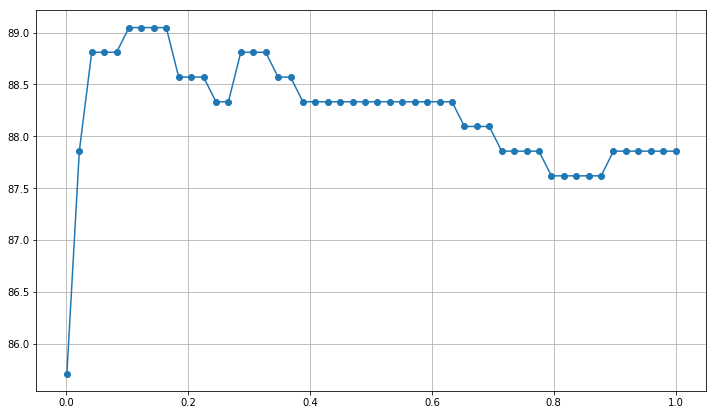

In [18]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(12, 7))
plt.plot(alphas, accuracy, 'o-')
plt.grid()
plt.show()

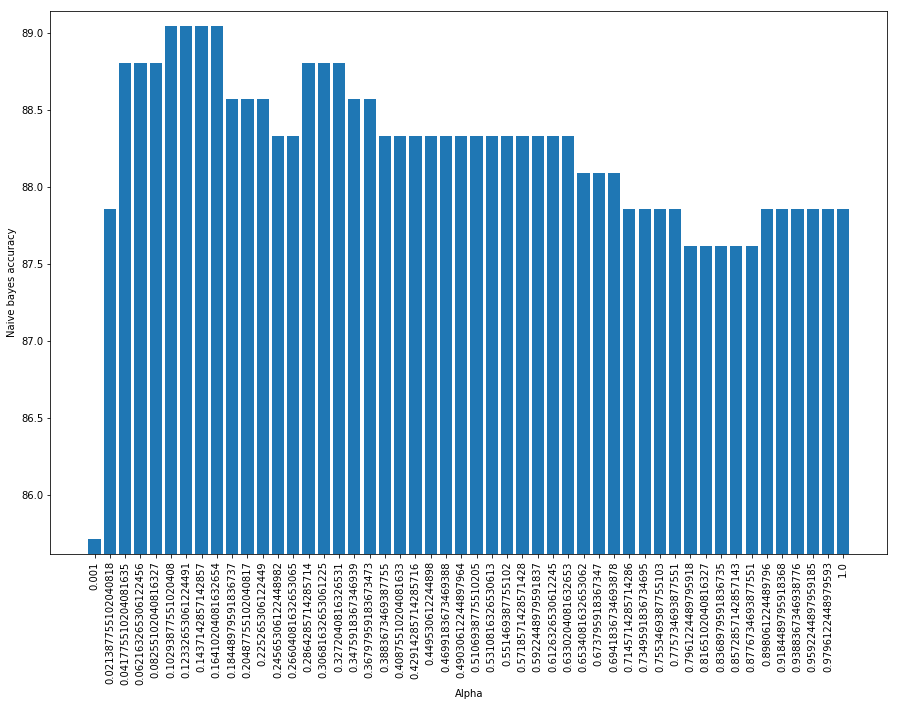

In [24]:
f, ax = plt.subplots(figsize=(15, 10))
plt.bar(range(len(alphas)), accuracy, align='center')
# https://matplotlib.org/gallery/ticks_and_spines/ticklabels_rotation.html#sphx-glr-gallery-ticks-and-spines-ticklabels-rotation-py
plt.xticks(range(len(alphas)), alphas, rotation='vertical')
plt.axis(ymin=min(accuracy) - .1, ymax= max(accuracy)+.1);
plt.xlabel("Alpha")
plt.ylabel("Naive bayes accuracy")


plt.show()